Dataset Basic info:

- Train images (and after agumentation):

        - Normal Images: 1349 (2338)
        - Virus images: 1345 (2341)
        - Bacteria images: 2538 (same)
        - Total: 5232

- Test images:

        - Normal Images: 234 (same)
        - Virus images: 148 (246)
        - Bacteria images: 242 (same)
        - Total: 624


In [2]:
# libraries
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
import json

# Chest X-Ray Pneumonia Prediction

Image size: (1858, 2090)
Image data type: uint8


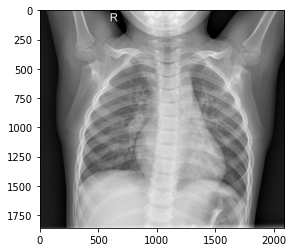

In [3]:
# Sample normal image
path = 'data/chest_pneumonia/train/normal'
img = cv2.imread(path + '/IM-0115-0001.jpeg', 0) # 1 = color, 0 = gray, -1 = unchanged
plt.imshow(img, cmap='gray')
# Basic info of the image
print('Image size:', img.shape)
print('Image data type:', img.dtype)

In [4]:
# Loading data
train_df = pd.read_csv('training_data.csv')
train_df.head()

,path,shape,rows,columns,label
0,data/chest_pneumonia/train/normal/train_h_aug_...,"(291, 291)",291,291,Healthy
1,data/chest_pneumonia/train/normal/NORMAL2-IM-0...,"(2234, 2359)",2234,2359,Healthy
2,data/chest_pneumonia/train/normal/train_h_aug_...,"(291, 291)",291,291,Healthy
3,data/chest_pneumonia/train/normal/train_h_aug_...,"(291, 291)",291,291,Healthy
4,data/chest_pneumonia/train/normal/train_h_aug_...,"(291, 291)",291,291,Healthy


In [5]:
test_df = pd.read_csv('test_data.csv')
test_df.tail()

,path,shape,rows,columns,label
717,data/chest_pneumonia/test/pneumonia/person120_...,"(688, 1024)",688,1024,Bacterial
718,data/chest_pneumonia/test/pneumonia/person171_...,"(672, 1088)",672,1088,Bacterial
719,data/chest_pneumonia/test/pneumonia/person109_...,"(808, 1256)",808,1256,Bacterial
720,data/chest_pneumonia/test/pneumonia/person83_b...,"(648, 912)",648,912,Bacterial
721,data/chest_pneumonia/test/pneumonia/person112_...,"(640, 952)",640,952,Bacterial


## Resizing images

In [6]:
max_rows_train = max(train_df['rows'])
max_cols_train = max(train_df['columns'])
max_rows_test = max(test_df['rows'])
max_cols_test = max(test_df['columns'])
biggest_dim = max(max_rows_train, max_cols_train, max_rows_test, max_cols_test)

In [7]:
# Training images

train_imgs = np.zeros([len(train_df), biggest_dim // 10, biggest_dim // 10], dtype = 'uint8')
for i in range(len(train_df)):
    img = cv2.imread(train_df['path'][i], 0)
    if img.shape != (biggest_dim //10, biggest_dim // 10):
        train_imgs[i] = cv2.resize(img, dsize=(biggest_dim //10, biggest_dim // 10), interpolation= cv2.INTER_CUBIC)
     
# Reshaping for keras input
train_imgs = train_imgs.reshape(train_imgs.shape[0], train_imgs.shape[1], train_imgs.shape[2], 1)

In [8]:
train_imgs.shape

(7217, 291, 291, 1)

In [9]:
# Test images
test_imgs = np.zeros([len(test_df), biggest_dim // 10, biggest_dim // 10], dtype = 'uint8')
for i in range(len(test_df)):
    img = cv2.imread(test_df['path'][i], 0)
    if img.shape != (biggest_dim //10, biggest_dim // 10):
        test_imgs[i] = cv2.resize(img, dsize=(biggest_dim //10, biggest_dim // 10), interpolation= cv2.INTER_CUBIC)
     
# Reshaping for keras input
test_imgs = test_imgs.reshape(test_imgs.shape[0], test_imgs.shape[1], test_imgs.shape[2], 1)

In [10]:
test_imgs.shape

(722, 291, 291, 1)

In [11]:
# Labels
le = LabelEncoder()
train_labels = np.array(train_df['label'])
test_labels = np.array(test_df['label'])
train_labels = le.fit_transform(train_labels)
test_labels = le.fit_transform (test_labels)

Now all the images are the same size and squared so the size is not affected by rotations or other image processing techniques. We can move on to data augmentation

## Image Augmentation

En el training set hay un poco menos del doble de imagenes de infeccion bacteriana que del resto, asi que voy a duplicar los otros 2 tipos usando el imagedatagenerator de keras.
En el test set hay unas 100 imagenes de menos en la categoria de virus, voy a hacer lo mismo con keras.

In [12]:
# Default value
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)

In [13]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, vertical_flip=True, horizontal_flip=True, shear_range=15)

In [14]:
test_df[test_df['label'] == 'Virus'].head(10)

,path,shape,rows,columns,label
234,data/chest_pneumonia/test/pneumonia/test_vir_a...,"(291, 291)",291,291,Virus
237,data/chest_pneumonia/test/pneumonia/test_vir_a...,"(291, 291)",291,291,Virus
238,data/chest_pneumonia/test/pneumonia/test_vir_a...,"(291, 291)",291,291,Virus
241,data/chest_pneumonia/test/pneumonia/person1647...,"(768, 1168)",768,1168,Virus
242,data/chest_pneumonia/test/pneumonia/person1675...,"(520, 952)",520,952,Virus
244,data/chest_pneumonia/test/pneumonia/person35_v...,"(1016, 1552)",1016,1552,Virus
247,data/chest_pneumonia/test/pneumonia/person1662...,"(672, 1160)",672,1160,Virus
248,data/chest_pneumonia/test/pneumonia/test_vir_a...,"(291, 291)",291,291,Virus
250,data/chest_pneumonia/test/pneumonia/person1669...,"(736, 1288)",736,1288,Virus
251,data/chest_pneumonia/test/pneumonia/test_vir_a...,"(291, 291)",291,291,Virus


Text(0.5, 1.0, 'Label: 0')

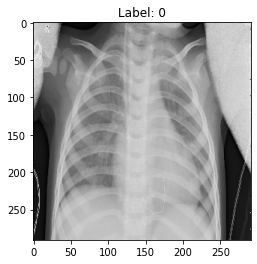

In [15]:
n = 256
plt.imshow(test_imgs[n], cmap='gray')
plt.title('Label: ' + str(test_labels[n]))
# 238, 241, 246, 247, 252, 256, 609

In [16]:
i = 0
for batch in datagen.flow(test_imgs[[238, 241, 246, 247, 252, 256, 609]], batch_size = 1, save_to_dir='new', save_prefix='test_vir_aug', save_format='jpeg'):
    i += 1
    if i >= 98:
        break

In [17]:
import os
for fil in os.listdir('new'):
    os.remove('new/' + fil)

# Creating a Model and training

In [18]:
# Building a model
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(filters=8, 
                        kernel_size=(3, 3), 
                        input_shape=(291, 291, 1), 
                        padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same"))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 291, 291, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 146, 146, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 146, 146, 8)       0         
_________________________________________________________________
flatten (Flatten)            (None, 170528)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                5456928   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 5,457,338
Trainable params: 5,457,338
Non-trainable params: 0
______________________________________________

In [19]:
# Compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.fit(train_imgs, train_labels, epochs=10, verbose=1)

Epoch 1/10
226/226 [==============================] - 120s 529ms/step - loss: 646.2290 - accuracy: 0.5345
Epoch 2/10
226/226 [==============================] - 110s 486ms/step - loss: 22.6829 - accuracy: 0.6899
Epoch 3/10
226/226 [==============================] - 114s 504ms/step - loss: 4.1808 - accuracy: 0.7674
Epoch 4/10
226/226 [==============================] - 111s 491ms/step - loss: 2.0611 - accuracy: 0.7976
Epoch 5/10
226/226 [==============================] - 114s 502ms/step - loss: 1.8080 - accuracy: 0.8048
Epoch 6/10
226/226 [==============================] - 112s 496ms/step - loss: 1.4835 - accuracy: 0.8211
Epoch 7/10
226/226 [==============================] - 123s 542ms/step - loss: 1.2350 - accuracy: 0.8213
Epoch 8/10
226/226 [==============================] - 115s 507ms/step - loss: 1.3492 - accuracy: 0.8195
Epoch 9/10
226/226 [==============================] - 124s 547ms/step - loss: 5.2464 - accuracy: 0.8235
Epoch 10/10
226/226 [==============================] - 124s 5

In [21]:
predictions = np.argmax(model.predict(test_imgs), axis=-1)

In [22]:
predictions_strings = le.inverse_transform(predictions)

In [42]:
model.evaluate(test_imgs, test_labels)

23/23 [==============================] - 4s 161ms/step - loss: 29.9015 - accuracy: 0.7280


[22.665781021118164, 0.7700831294059753]

In [29]:
# Saving the model
model.save('model_pneu.h5')